In [141]:
import numpy as np
import scipy.integrate as integrate
from astropy.cosmology import WMAP9 as cosmo
from astropy import constants
from astropy import units as u
import scipy.interpolate
import time
from scipy.optimize import curve_fit
import math
from numba import njit

In [142]:
import matplotlib as mpl
mpl.use('pgf')
import matplotlib.pyplot as plt
from cycler import cycler
import matplotlib.ticker as mticker
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
%matplotlib inline

myColors = ["#009E73", "#0072B2", "#CC79A7", "#D55E00", "#56B4E9", "#F0E442", "#E69F00", "#000000"]
colors= ["white", myColors[4], myColors[1], myColors[0], myColors[5], myColors[6], myColors[3]]
myNodes = [0.0, 0.1, 0.2, 0.35, 0.5, 0.85, 1.0]
myCmap = mpl.colors.LinearSegmentedColormap.from_list("mycmap", list(zip(myNodes, colors)))

colorsLog= ["white",  myColors[4], myColors[1], myColors[6], myColors[3], myColors[3]]
myNodesLog = [0.0, 0.1 , 0.2, 0.36, 0.6, 1]
myCmapLog = mpl.colors.LinearSegmentedColormap.from_list("mycmapLog", list(zip(myNodesLog, colorsLog)))

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 15

mpl.rcParams['agg.path.chunksize'] = 10000
plt.rcParams.update({
	'font.family':'serif',
	'mathtext.fontset' : 'cm',
	'mathtext.rm': 'serif',
	'font.weight': 'normal',
	})
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) 
plt.rcParams.update({'font.size': 15})

mpl.rcParams['axes.prop_cycle'] = cycler(color=myColors)

In [143]:

def RescalingCenters(DataSet, Nbins, Bins_limit=None):

    if Bins_limit==None:
        bins_max=DataSet[-1][0]
        bins_min=DataSet[0][0]
    else:
        bins_max=Bins_limit[1]
        bins_min=Bins_limit[0]
        
    x_data=DataSet[:,0]
    bins_edges = np.logspace(np.log10(bins_min), np.log10(bins_max), Nbins+1)
    bins_centers = np.array([0.5 * (bins_edges[i] + bins_edges[i+1]) for i in range(Nbins)])
    y_data=DataSet[:,1]

    y_stackable = np.zeros(Nbins)

    for j in range(Nbins):
        for i in range(len(x_data)):
            if (x_data[i]<bins_edges[j+1])and(x_data[i]>bins_edges[j]):
                x_data[i]=bins_centers[j]
                y_stackable[j]=round(y_data[i])
            else:
                pass
        
    return bins_edges, bins_centers,  y_stackable

In [144]:
def DataStack(DataSets, Nbins, Bins_limit=None):

    if Bins_limit==None:
        a=np.empty(len(DataSets), dtype=object)
        for i in range(len(DataSets)):
            a[i] = DataSets[i][:,0]
        a=np.concatenate(a)
        
        bins_max=max(a)

        bins_min=min(a)

        bins_limit=(bins_min, bins_max)
    else:
        bins_max=Bins_limit[1]
        bins_min=Bins_limit[0]


    y_stacked = np.zeros(Nbins)
    for i in range(len(DataSets)):

        bins_edges, bins_center, y_stackable = RescalingCenters(DataSets[i], Nbins, Bins_limit=(bins_min, bins_max))
        y_stacked += y_stackable
    

    return bins_edges, bins_center, y_stacked

In [145]:
pathfit_susa = '/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/Fit/Susa2014/'
name_N_per_halo = 'Stars_per_minihalo'
N_per_halos = np.rint(np.genfromtxt(pathfit_susa + 'N_per_halos' +'.csv'))
x_bins=np.arange(1,7,1)


In [146]:
def PowerLaw(x, A, a):
    return A*np.exp(-x*a)

def PowerLaw_norm(x, A, a):
    N_NH = integrate.quad(PowerLaw, 0.5, 7.5, args=(A, a))[0]
    return A*np.exp(-x*a)/N_NH


In [147]:
x_fit_NH = np.arange(1, 7, 0.1)
sample=[]
popt, pcov = curve_fit(PowerLaw, x_bins, N_per_halos,  bounds=([18, 0], [30, 10]))
y_fit_NH = PowerLaw(x_fit_NH, *popt)
A, a = popt
N_tot = np.sum(N_per_halos)

Text(0, 0.5, 'Number of halo')

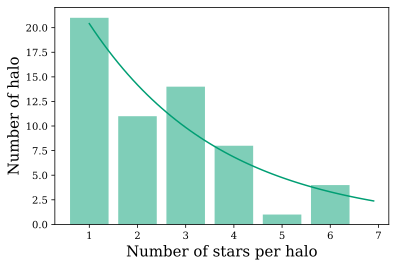

In [148]:
plt.bar(x_bins, N_per_halos, alpha = 0.5)
plt.plot(x_fit_NH, y_fit_NH, color=myColors[0])

plt.xlabel('Number of stars per halo')
plt.ylabel('Number of halo')

In [149]:
N_per_halos_z30 = np.array([0.8, 0.2, 0., 0., 0., 0.])
popt30, pcov30 = curve_fit(PowerLaw, x_bins, N_per_halos_z30,  bounds=([18, 0], [30, 10]))
y_fit_NH_30 = PowerLaw(x_fit_NH, *popt30)

A30, a30 = popt30

In [456]:
N_NH = integrate.quad(PowerLaw, 1, 7, args=(A, a))[0]
N_per_halos_z10 = N_per_halos/N_NH

popt10, pcov10 = curve_fit(PowerLaw_norm, x_bins, N_per_halos_z10,  bounds=([0, 0], [30, 10]))
y_fit_NH_10 = PowerLaw(x_fit_NH, *popt10)

A10, a10 = popt10

n = np.linspace(0.5, 7.5, 100)
N_star_prob = scipy.interpolate.interp1d(n, PowerLaw(n, A10, a10), kind='cubic')

Text(0, 0.5, 'Number of halo')

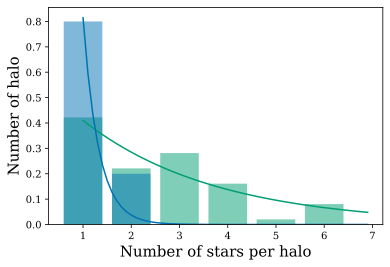

In [152]:
y_fit_norm = y_fit_NH/N_NH

plt.plot(x_fit_NH, y_fit_NH_10, color=myColors[0])
plt.bar(x_bins, N_per_halos_z10, alpha = 0.5)
plt.bar(x_bins, N_per_halos_z30, alpha = 0.5)
plt.plot(x_fit_NH, y_fit_NH_30, color=myColors[1])

plt.xlabel('Number of stars per halo')
plt.ylabel('Number of halo')


In [153]:
def Az(z):
    # A_int = scipy.interpolate.UnivariateSpline((10, 30),(A10, A30))
    A_int =  scipy.interpolate.krogh_interpolate((10, 30),(A10, A30), z)
    return float(A_int)

def az(z):
    # a_int = scipy.interpolate.UnivariateSpline((10, 30),(a10, a30))
    a_int =  scipy.interpolate.krogh_interpolate((10, 30),(a10, a30), z)
    return float(a_int)

def PowerLaw_PDF_Z(n_s, z):
    def PowerLaw_z(n_s, z):
        A = Az(z)
        a = az(z)
        N_NH = integrate.quad(PowerLaw, 1, 7, args=(A, a))[0]
        return A*np.exp(-n_s*a)/N_NH
    v= np.vectorize(PowerLaw_z)
    return v(n_s, z)

In [154]:
n_s = np.linspace(1, 7, 100)
z = np.linspace(10, 30, 100)

x, y = np.meshgrid(n_s, z)

pl = np.array(PowerLaw_PDF_Z(x, y))

N_star_prob = scipy.interpolate.interp2d(n_s, z, pl, kind='cubic')

In [459]:
def N_star_pdf(n_s):
    n = np.vectorize(N_star_prob)
    return n(n_s)

Text(0, 0.5, '$P(N_*)$')

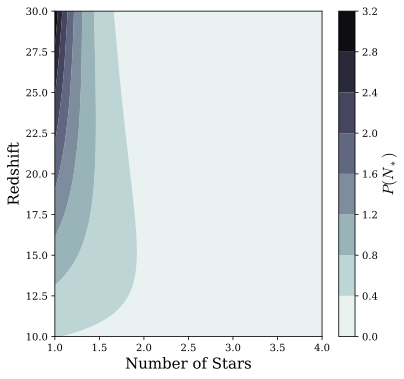

In [156]:
fig1, ax2 = plt.subplots(figsize=(6 , 6))

origin = 'lower'

n_s = np.linspace(1, 7, 100)
z = np.linspace(10, 30, 100)

CS = ax2.contourf(n_s, z, N_star_prob(n_s, z), cmap=plt.cm.bone_r, origin=origin)

ax2.set_xlabel('Number of Stars')
ax2.set_ylabel('Redshift')
ax2.set_xlim(1, 4)

# CS2 = ax2.contour(CS, levels=CS.levels[::1], colors='r', origin=origin)
cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel('$P(N_*)$')

# cbar.add_lines(CS2)

We want to build a monte carlo that return the number of star par mass of halos with an associated mass. 
To do so we needed the IMF of the halos, the distribution of stars in the halos and their IMFwe have now everything we wanted to perform this.

In [157]:
from PS_class import HaloMassFunction

In [434]:
HMF = HaloMassFunction(0, logmass_lim=(4, 20), Nbins=100)

gen = np.random.default_rng()

H_IMF = HMF.IMF

z = np.linspace(10, 30, 100)
Mh_interval=(10**4, 10**8)
m = np.logspace(np.log10(Mh_interval[0]), np.log10(Mh_interval[1]), 100)

In [435]:
xh, yh = np.meshgrid(m, z)

h = H_IMF(xh, yh)

In [436]:
h_inter = scipy.interpolate.interp2d(m, z, h, kind='cubic')

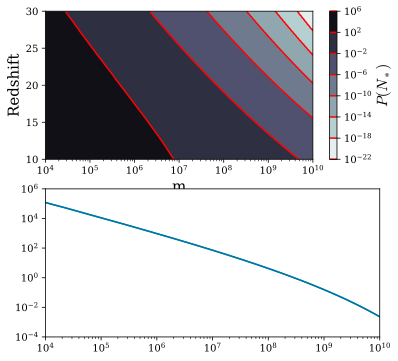

In [161]:
fig1, ax2 = plt.subplots(2, figsize=(6 , 6))

origin = 'lower'

CS = ax2[0].contourf(m, z, h_inter(m,z), cmap=plt.cm.bone_r, origin=origin, locator=mpl.ticker.LogLocator())

ax2[0].set_xlabel('m')
ax2[0].set_xscale('log')
ax2[0].set_ylabel('Redshift')
CS2 = ax2[0].contour(CS, levels=CS.levels[::1], colors='r', origin=origin)
cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel('$P(N_*)$')
m2 = np.logspace(4, 15, 100)
ax2[1].plot(m2, h_inter(m2, 10))
ax2[1].set_xscale('log')
ax2[1].set_yscale('log')
ax2[1].plot(m2, H_IMF(m2, 10))
ax2[1].set_xscale('log')
ax2[1].set_yscale('log')

ax2[1].set_ylim(1e-4,1e6)
ax2[1].set_xlim(1e4,1e10)

cbar.add_lines(CS2)

In [162]:
def halo_PDF_norm(z):
    return integrate.quad(h_inter, Mh_interval[0], Mh_interval[1], args=(z), epsrel=1e-4, limit=1000)[0]

halo_PDF_norm(11)

7322122484.518658

In [163]:
from PS_class import GrowthFunction

GF = GrowthFunction()

In [164]:
from PS_class import Overdensities
O=Overdensities(0)
def derivative(M):
        sigma = O.S(M)
        sigma_plus = O.S(1.000000001*M)
        return (sigma_plus-sigma)/(0.000000001*M)

def M_finder(M0, sigma):
        return float(scipy.optimize.fsolve(lambda x: O.S(x)-sigma, M0))

m_finder =np.vectorize(M_finder)
        
def S_for_M(M, sigma_MF):
    return O.S(M)-sigma_MF



In [830]:
Mh_interval=(10**4, 10**8)
def HalosGenerator(M_max, z):

    norm = halo_PDF_norm(z)

    def pdf(m):
        return h_inter(m, z)/norm
    
    m_int = np.logspace(4, 10, 100)
    pdf_int = scipy.interpolate.interp1d(m_int, pdf(m_int))

    fmax=pdf_int(Mh_interval[0])+0.02*pdf_int(Mh_interval[0])
    x_output=np.array([])
    
    m=0
    t=[]
    while m<M_max:

        # t0 = time.time()
        # t.append(time.time()-t0)

        x = gen.uniform(*Mh_interval, 10000)
        y = gen.uniform(0, fmax, 10000)

        x_accepted = x[(y <= pdf_int(x))]
        x_output = (np.append(x_output, x_accepted)).flatten()
        m+=np.sum(x_accepted)

        

        # if(ii>=100):
        #     t_tot =np.mean(t)*ninput
        #     print(" Time for 1 loop is approx:", np.mean(t)
        #         , "\n Comp is finished in ", t_tot, "s"
        #         , " = " , t_tot/60 , "min" )
    
    return x_output



In [444]:
h = HalosGenerator(1e9, 20)

39356925.43996814 8
39462115.89291885 11
41212502.86786567 15
42025496.86854963 19
42025496.86854963 19
42522951.073130965 21
43343668.46704889 24
43904940.704163656 28
44423176.45621085 31
44605581.81463664 33
44663239.867133014 34
45112173.18103737 37
45112173.18103737 37
45555426.55709502 40
45568021.13552892 41
45611354.01149994 43
45611354.01149994 43
46450897.412434004 46
46565303.10247005 48
46857219.71601708 49
47004865.86323646 51
47430845.83501177 54
48297427.552203976 57
48877656.377112456 59
48905244.38797774 61
50696557.84015457 64
50747407.70943521 65
53804386.81394129 70
55472861.07059096 73
55531310.44766913 74
55531310.44766913 74
67839996.46871647 78
68138897.07337652 81
68138897.07337652 81
68138897.07337652 81
68425347.8871642 86
68425347.8871642 86
71792198.7263223 90
71834723.80719894 91
72183387.43711792 93
72508270.98477907 95
72538256.40489516 97
72555331.33614755 98
72580044.17112255 99
73578397.51112284 100
75351658.17927696 101
75654334.17400959 105
75949763

In [ ]:
len(h)

In [488]:
def N_StarGenerator(m_Hs, z):

    fmax=N_star_pdf(0.5)+0.02*N_star_pdf(0.5)
    x_output=np.array([])
    y_output=np.array([])

    ninput=len(m_Hs)
    
    ii = 0
    t = []
    while ii<ninput:

        x = gen.uniform(0.5, 7.5, ninput)
        y = gen.uniform(0, fmax, ninput)

        x_accepted = x[(y <= N_star_pdf(x))]
        x_output = (np.append(x_output, x_accepted)).flatten()
        y_accepted = y[(y <= N_star_pdf(x))]
        y_output = (np.append(y_output, y_accepted)).flatten()
        ii+=len(x_accepted)
        # print('N_star', ii)

        x_output = x_output[:ninput]
        y_output = y_output[:ninput]
        
    
    return (np.rint(x_output)).astype(int), (np.rint(m_Hs/10**6*x_output)).astype(int), y_output

    


0.0 0
0.0 0
102014.00047501987 1
102014.00047501987 1
205235.87631050893 4
205235.87631050893 4
231930.28354719083 6
334223.92812242813 8
365128.0387882302 9
402435.58977405465 10
402435.58977405465 10
402435.58977405465 10
497076.1776383502 14
508481.76764247887 15
535650.2549846692 16
548708.6442945544 17
548708.6442945544 17
567150.0392113894 18
847070.6194319103 21
969599.5440502468 22
1077482.1179370377 25
1077482.1179370377 25
1077482.1179370377 25
1157686.8121543946 28
1173302.2261797069 29
1173302.2261797069 29
1253457.0253276215 31
1333651.7344009716 33
1456245.241495179 35
1961170.460417662 41
1989146.504599795 43
1989146.504599795 43
2019528.7693843972 45
2049290.837045095 47
2066622.2560343833 48
2066622.2560343833 48
2084771.9624449057 49
2120495.124776992 51
2146348.5933293537 52
2156370.1131924 53
2213007.583554609 55
2368144.2931496114 57
3380108.495190026 58
3393116.315983784 59
3404597.861233079 60
3404597.861233079 60
3404597.861233079 60
3419970.145171918 61
3419970

(0.0, 10.0)

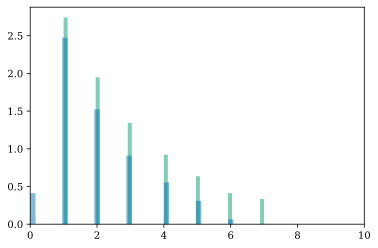

In [469]:
h = HalosGenerator(1e9, 30)
n0, n1, _  = N_StarGenerator(h, 0)
plt.hist(n0, 50, density=True, alpha = 0.5)
plt.hist(n1, 50, density=True, alpha = 0.5)
plt.xlim(0, 10)

In [167]:
def Gaussian(x, s, mu):
    return (1 / (s*np.sqrt(2 * np.pi))) * np.exp(-(x - mu)**2 / (2 * s**2))

In [168]:
def Double_Gaussian(x, s1, mu1, A1, s2, mu2, A2):
    return A1 * np.exp(-(x - mu1)**2 / (2 * s1**2)) + A2 * np.exp(-(x - mu2)**2 / (2 * s2**2))

In [169]:
def HistMaker(bar_edges, bar_centers, bar_Y):
    data = []
    for i in range(len(bar_edges)-1):
        ii=1
        l1= len(data)
        while ii<=bar_Y[i]:
            data.append(np.log10(bar_centers[i]))
            ii+=1
        l2 = len(data)
        # print(l2-l1, bar_Y[i], np.array(data)[l1:l2])
    return data

In [170]:
#Hirano 2015
name_Hirano2015 = ['Total', '10<z<14', '14<z<18', '18<z<22', '22<z<26', '26<z<30', 'Bins']

pathfit_Hirano2015= '/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/Fit/Hirano2015/'
Hirano2015 = np.empty(len(name_Hirano2015), dtype=object)
for i in range(len(name_Hirano2015)):
    Hirano2015[i] = np.genfromtxt(pathfit_Hirano2015 + name_Hirano2015[i] +'.csv', delimiter=';')

Nbins_Hirano2015 = len(Hirano2015[0])
Bins_Hirano2015_min = min(Hirano2015[-1][:,0])
Bins_Hirano2015_max = max(Hirano2015[-1][:,0])
Bins_limit_Hirano2015=(Bins_Hirano2015_min, Bins_Hirano2015_max)


Hirano2015_Y=np.empty(len(Hirano2015), dtype=object)
Hirano2015_edges = np.empty(len(Hirano2015), dtype=object)
Hirano2015_centers = np.empty(len(Hirano2015), dtype=object)
Data_Hirano2015 = np.empty(len(Hirano2015), dtype=object)

for i in range(len(Hirano2015)):
    Hirano2015_edges[i], Hirano2015_centers[i], Hirano2015_Y[i] = RescalingCenters(Hirano2015[i], Nbins_Hirano2015, Bins_limit=Bins_limit_Hirano2015)
    Data_Hirano2015[i]= HistMaker(Hirano2015_edges[i], Hirano2015_centers[i], Hirano2015_Y[i])


(0.9911086115606538, 2.324458683825721e-09)
[0.11683528 1.3816745  1.40116422 0.25327232 2.18074878 0.91478506]
(0.9401219023557018, 2.246588450197768e-09)
[0.14016337 2.         0.53677288 0.1554906  2.35955187 1.92820967]
[0.15636607 2.43724364]
[0.09545854 2.51981353]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.125979   2.52119741]


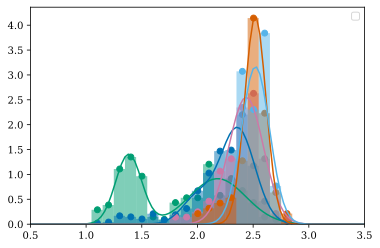

In [171]:
Hirano2015_popts = np.empty(5, dtype=object
                            )
for i in range(1, len(Data_Hirano2015)-1):
    mfit_pop3_h2015 = np.linspace(0.5, 3.5, 100)
    bin_entries, _, _  = plt.hist(Data_Hirano2015 [i], bins=np.linspace(np.log10(Bins_limit_Hirano2015[0]), np.log10(Bins_limit_Hirano2015[1]), 21), alpha = 0.5, density=True, color=myColors[i-1])   

    mask=(Hirano2015_Y[i]!=0)
    Hirano2015_centerf = np.log10(Hirano2015_centers[i])[mask]
    plt.scatter(np.log10(Hirano2015_centers[i])[mask], bin_entries[mask], color=myColors[i-1])


    if i<3:
        Hirano2015_popts[i-1], Hirano2015_pcov = curve_fit(Double_Gaussian, Hirano2015_centerf, bin_entries[mask], bounds=([0, 1, 0, 0, 2, 0],[1, 2, 10, 1, 3, 10]))
        s1, mu1, A1, s2, mu2, A2 = Hirano2015_popts[i-1]
        norm = integrate.quad(Double_Gaussian, 0.5, 3.5, args = (s1, mu1, A1, s2, mu2, A2, ))
        print(norm)
        plt.plot(mfit_pop3_h2015, Double_Gaussian(mfit_pop3_h2015, *Hirano2015_popts[i-1]), color=myColors[i-1])
    elif i>=3:
        Hirano2015_popts[i-1], Hirano2015_pcov = curve_fit(Gaussian, Hirano2015_centerf, bin_entries[mask], bounds=([0,2],[1, 3]))
        plt.plot(mfit_pop3_h2015, Gaussian(mfit_pop3_h2015, *Hirano2015_popts[i-1]), color=myColors[i-1])
    
    print(Hirano2015_popts[i-1]) 

# plt.ylim(1, 1000)
plt.xlim(0.5, 3.5)
# plt.yscale('log')
plt.legend()

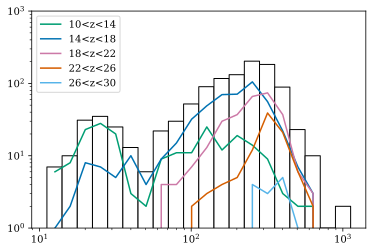

In [172]:
plt.bar(Hirano2015_edges[0][:-1], Hirano2015_Y[0], width=np.diff(Hirano2015_edges[i]), ec="k", align="edge", color='white')
for i in range(1, len(Hirano2015)-1):
    plt.plot(Hirano2015_centers[i], Hirano2015_Y[i], label=f'{name_Hirano2015[i]}')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1, 1000)
plt.legend()

In [173]:
s1, mu1, A1, s2, mu2, A2 = Hirano2015_popts[0]
norm1 = integrate.quad(Double_Gaussian, 0.5, 3.5, args = (s1, mu1, A1, s2, mu2, A2, ))
s1, mu1, A1, s2, mu2, A2 = Hirano2015_popts[1]
norm2 = integrate.quad(Double_Gaussian, 0.5, 3.5, args = (s1, mu1, A1, s2, mu2, A2, ))

def Hirano2015_pdf(M, z):
    if 10<z and z<14:
        return Double_Gaussian(np.log10(M), Hirano2015_popts[0])/norm1
    elif 14<z and z<18:
        return Double_Gaussian(np.log10(M), Hirano2015_popts[1])/norm2
    elif 18<z and z<22:
        return Gaussian(np.log10(M), Hirano2015_popts[2])
    elif 22<z and z<26:
        return Gaussian(np.log10(M), Hirano2015_popts[3])
    elif 26<z and z<30:
        return Gaussian(np.log10(M), Hirano2015_popts[4])
    

In [174]:
pathfit_susa = '/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/Fit/Susa2014/'
name_susa = ['Bins edges', 'Hist']

Susa = np.genfromtxt(pathfit_susa + name_susa[1] +'.csv', delimiter=';')
Bins_limit_Susa=np.genfromtxt(pathfit_susa + name_susa[0] +'.csv', delimiter=';')[:,0].tolist()
Nbins_Susa = 20
Bins_limit_Susa

[0.464926482, 295.3916929]

In [175]:
Susa_edge, Susa_center, Susa_Y = RescalingCenters(Susa, Nbins_Susa, Bins_limit=Bins_limit_Susa)
Data_Susa_i = HistMaker(Susa_edge, Susa_center, Susa_Y)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.52420984 1.38007314]


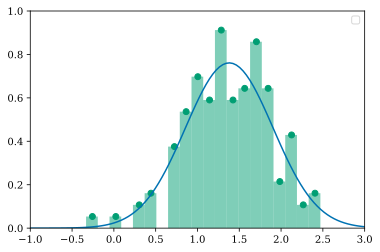

In [176]:
mfit_pop3 = np.linspace(-1, 3, 100)
bin_entries, _, _  = plt.hist(Data_Susa_i, bins=np.linspace(np.log10(Bins_limit_Susa[0]), np.log10(Bins_limit_Susa[1]), 21), alpha = 0.5, density=True)   

mask=(Susa_Y!=0)
Susa_centerf = np.log10(Susa_center)[mask]
plt.scatter(np.log10(Susa_center)[mask], bin_entries[mask])

Susa_popt, Susa_pcov = curve_fit(Gaussian, Susa_centerf, bin_entries[mask], bounds=([0,0],[10, 2]))

plt.plot(mfit_pop3, Gaussian(mfit_pop3, *Susa_popt))
print(Susa_popt) 

plt.ylim(0, 1)
plt.xlim(-1, 3)
plt.legend()

In [177]:
def Susa_IMF_PDF(m, z):
    return Gaussian(np.log10(m), *Susa_popt)

def Susa_IMF_PDF_log(logm, z):
    """
    this pdf is normlaized only for the log of the mass!
    """
    return Gaussian(logm, *Susa_popt)


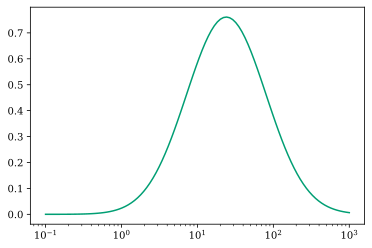

In [178]:
M=np.logspace(-1, 3, 100)
plt.plot(M, Susa_IMF_PDF(M, 10))
plt.xscale('log')

In [179]:
from scipy.stats import loguniform

def Mass_Star_Generator(ninput, z, PDF, logm_interval):
    m_max = np.logspace(logm_interval[0],  logm_interval[1], 100)
    pdfmax = np.max(PDF(m_max, z))
    fmax = pdfmax+0.02*pdfmax
    x_output = np.array([])
    
    ii = 0
    while ii<ninput:

        x = loguniform.rvs(10**logm_interval[0], 10**logm_interval[1], size=ninput)
        y = gen.uniform(0, fmax, ninput)

        x_accepted = x[(y <= PDF(x, z))]
        x_output = (np.append(x_output, x_accepted)).flatten()
        ii+=len(x_accepted)
        # print('Mass star', ii)

        x_output = x_output[:ninput]
    
    return x_output


In [180]:
star = Mass_Star_Generator(10000, 10, Susa_IMF_PDF, (-1, 3))

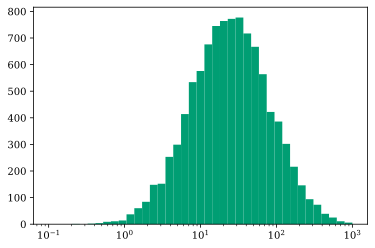

In [181]:
m = np.logspace(-1, 4, 100)
plt.hist(star, density=False, bins=10**np.linspace(-1,3,40))
# plt.plot(m, Susa_IMF_PDF(m, 10))
plt.xscale('log')

In [753]:
H0= (67.66 * u.km * u.s**-1 * u.Mpc**-1).to(u.yr**-1).value
omega_m = 0.3103
omega_l = 0.6897

@njit
def Time_z(z):
    a = 1/(1 + z)
    denom = H0*3*np.sqrt(a * omega_l * (a**3 * omega_l + omega_m) / a)
    num = 2 * np.sqrt(a**3 * omega_l + omega_m) * np.arctanh(np.sqrt(a**3 * omega_l / (a**3 * omega_l + omega_m)))

    return num / denom

@njit
def Redshift_t(t):
    denom = (omega_l - omega_l * np.tanh(3 / 2 * H0 * t * np.sqrt(omega_l))**2)**(1/3)
    num = omega_m**(1/3) * np.tanh(3 / 2 * H0 * t * np.sqrt(omega_l))**(2/3)
    return denom/num-1

_ = Time_z(30)
_ = Redshift_t(3000000000)


In [788]:
dt = 1e7

t_i = Time_z(30)
t_f = Time_z(20)

n_step = int(np.rint((t_f - t_i)/dt))

print('The simulatation will start at $t_i=$', t_i, 'and finish at $t_f=$', t_f, '. There will be ' , n_step, 'steps')

The simulatation will start at $t_i=$ 100203870.4539359 and finish at $t_f=$ 179715743.9834926 . There will be  8 steps


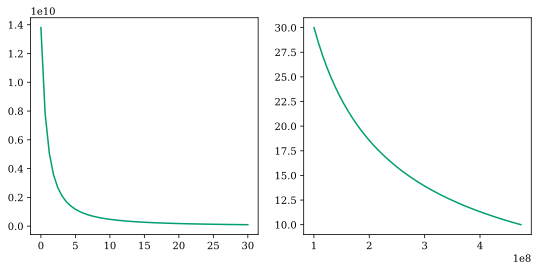

In [735]:
z1 = np.linspace(0, 30, 50)
t1 = Time_z(z1)

t2 = np.linspace(100203870, 473939176, 50)
z2 = Redshift_t(t2)

fig, ax = plt.subplots(1, 2, figsize = (9, 4))

ax[0].plot(z1, t1)
ax[1].plot(t2, z2)

In [832]:



def redhsift_steps(step_number, dt, n_step):
    if step_number <= n_step:
        steped_time = t_i + step_number*dt
        return Redshift_t(steped_time)
    else:
        return False
z = []
simulation_finished = True

i = 0
while simulation_finished:
    simulation_finished = redhsift_steps(i, dt, n_step)
    z.append(simulation_finished)
    if not simulation_finished:
        z = z[:-2]
    i+=1

print(z)

[29.99999999999999, 28.095067711559082, 26.45812071409648, 25.033523433787085, 23.780376955347425, 22.667885160903985, 21.672378682820526, 20.77534027843501]


In [839]:
def Redshift_routine(z_i, z_f, dt):

    t_i = Time_z(z_i)
    t_f = Time_z(z_f)

    n_step = int(np.rint((t_f - t_i)/dt))
    print('There will be ', n_step, 'steps')
    z = []
    simulation_finished = True

    i = 0
    while simulation_finished:
        simulation_finished = redhsift_steps(i, dt, n_step)
        z.append(simulation_finished)
        if not simulation_finished:
            z = z[:-2]
        i+=1

    return z

In [822]:
def Mass_routine(z):
    
    H_z = []
    M_popIII_z = []
    for i in range(len(z)):
        Halos = HalosGenerator(1e9, z[i])
        H_z.append(Halos)
        Ns = N_StarGenerator(Halos, z[i])[1]
        m_popIIIs = []
        for n in Ns:
            m_popIIIs = np.concatenate((m_popIIIs, Mass_Star_Generator(n, z[i], Susa_IMF_PDF, (-1, 3)).tolist()))
        M_popIII_z.append(m_popIIIs)
    return H_z, M_popIII_z

In [790]:
z_i = z[0]
z_f = z[-1]

H_z = []
M_popIII_z = []
for i in range(len(z)):
    Halos = HalosGenerator(1e9, z[i])
    H_z.append(Halos)
    Ns = N_StarGenerator(Halos, z[i])[1]
    m_popIIIs = []
    for n in Ns:
        m_popIIIs = np.concatenate((m_popIIIs, Mass_Star_Generator(n, z[i], Susa_IMF_PDF, (-1, 3)).tolist()))
    M_popIII_z.append(m_popIIIs)
    print(z[i])
    

0.0 0
33591.14959059152 2
60662.55089601331 3
60662.55089601331 3
103018.80861556731 4
136417.69418875768 6
160175.85052896198 7
391242.6624815112 9
428307.3137429989 11
466092.9673666431 12
466092.9673666431 12
537091.3637510841 14
566779.8134786984 15
566779.8134786984 15
579726.5247784073 16
629942.8546073607 17
666412.5929545622 19
774458.639808104 23
867525.3022878855 25
879747.6838098831 26
904155.0565791085 27
904155.0565791085 27
1002762.2814224502 28
1044894.1019362818 29
1076495.3144173017 30
1174083.2198984774 32
1194809.0377846581 34
1219617.2521373164 36
1270401.9435171129 39
1296255.866526546 41
1722499.4347168922 43
1722499.4347168922 43
1827894.4347836783 44
1840991.662605701 45
1853208.7850194562 46
1891795.5365119968 48
1891795.5365119968 48
1967961.5812379092 50
2020538.5623288078 52
2081364.5922023598 53
2115587.8061510376 55
2154701.699838136 56
2168075.2012955546 57
2168075.2012955546 57
2182498.9696807493 58
2275034.162041095 60
2275034.162041095 60
2290666.63666

In [214]:
G=(constants.G*constants.M_sun).to(u.kpc**3/u.s**2)
Msun= constants.M_sun
Rsun = 696340*u.km


<Quantity 4.51710305e-39 kpc3 / s2>

In [820]:
norm_a = integrate.quad(lambda k: k**-1, 6957000, 2000*695700)[0]
# norm = integrate.quad(lambda k: k**-1, 0, np.inf)[0]

def a_pdf(x):
    return 1/norm_a/x

def a_generator(n, amin):
    amin = amin.value
    fmax = a_pdf(amin)+0.01*a_pdf(amin)
    ii=0
    x_output=np.array([])
    while ii<n:
        y = np.random.uniform(0, fmax, 1000)
        x = np.random.uniform(amin, 2000*695700, 1000)
        mask = y<a_pdf(x)
        x_output = np.append(x_output, x[mask])
        ii+=len(x[mask])
    return x_output[:n]

def e_pdf(e, ai, amin):
    emax = 1 - amin.value/ai.value
    norm_e = integrate.quad(lambda k: k, 0, emax)[0]
    return e/norm_e

def e_generator(n, ai, amin):
    emax = 1 - amin.value/ai.value
    fmax = e_pdf(emax, ai, amin)+0.01*e_pdf(emax, ai, amin)
    ii=0
    x_output=np.array([])
    while ii<n:
        y = np.random.uniform(0, fmax, 1000)
        x = np.random.uniform(0, emax, 1000)
        mask = y<e_pdf(x, ai, amin)
        x_output = np.append(x_output, x[mask])
        ii+=len(x[mask])
    return x_output[:n]

_ = a_pdf(1000000)
_ = e_pdf(0.9, 700000*u.km, 500000*u.km,)

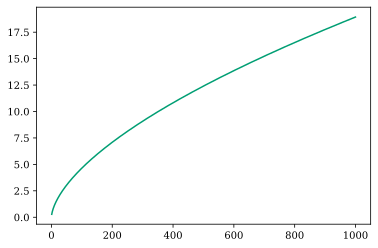

In [778]:
m = np.linspace(1, 1000, 1000)
R1 = (0.28*(m)**0.61)

plt.plot(m, R1)

In [784]:
@njit
def g_e(e):
    return (1-e**2)**(7/2)/(1+(73/24)*e**2+(37/96)*e**4)

Rsun = 696340*u.km
Msun= constants.M_sun
c=constants.c.to(u.km/u.s)
G=constants.G.to(u.km**3/u.s**2/u.kg)

def Merging_Time(M1, M2):

    M1 = max((M1, M2))
    M2 = min((M1, M2))

    M1 = M1*Msun
    M2 = M2*Msun

    mu = M1*M2/(M1+M2)
    m = M1+M2
    nu = mu/m

    q= (M2/M1).value

    R1 = (0.28*Rsun*(M1/Msun)**0.61)

    amin2 = ((0.6 * math.pow(q, 2/3) + np.log(1 + math.pow(q, 1/3))) / (0.49 * math.pow(q, 2/3)) * R1 / Rsun).value
    
    amin= max((6957000., amin2))*u.km

    
    # v=265*u.km/u.s

    a = a_generator(1, amin)[0]*u.km
    e = e_generator(1, a, amin)[0]
    

    #t = (((5/256) * (c**5 / G**3 / m**2 / mu * a**4) + c**5 * G * m / nu / v**8).to(u.yr)).value
    t = (((5/256) * (c**5/G**3*a**4)/(M1*M2*(M1+M2))*g_e(e)).to(u.yr)).value
    return t

_ = g_e(0.9)
_ = Merging_Time(1e6, 1e6)


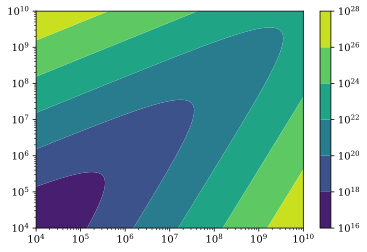

In [583]:
def Merging_Time_(M1, M2):

    M1 = M1*constants.M_sun
    M2 = M2*constants.M_sun

    mu = M1*M2/(M1+M2)
    m = M1+M2
    nu = mu/m

    c=constants.c.to(u.km/u.s)
    G=constants.G.to(u.km**3/u.s**2/u.kg)
    v=265*u.km/u.s
    r=10*695700*u.km
    t = (((5/256) * (c**5/G**3/m**2/mu*r**4) - c**5 * G * m /nu / v**8).to(u.yr)).value
    # - c**5 * G * m /nu / v**8
    return t

from matplotlib import ticker, cm
Merging_Time_(1e6, 1e6)
m1=np.logspace(4,10, 100)
m2=np.logspace(4,10,100)
x, y = np.meshgrid(m1, m2)
MT = Merging_Time_(x, y)

fig, ax = plt.subplots()
cs = ax.contourf(x, y, MT, locator=ticker.LogLocator())
cbar = fig.colorbar(cs)
ax.set_xscale('log')
ax.set_yscale('log')


In [818]:
M1_z = []
M2_z = []
t_merge_z = []
t_merge = []
chirp_mass_z = []

for i in range(len(z)):

    print(np.sum(H_z[i]), z[i])

    mz = np.sum(np.array(M_popIII_z[i]))
    n = len(M_popIII_z[i])

    M1=[]
    M2=[]
    binaries = []
    z_binaries = []
    chirp_mass = []
    a=0
    
    for s in range(int(n/4)):
        M1.append(M_popIII_z[i][2*s])
        M2.append(M_popIII_z[i][2*s+1])
        
        binaries.append(Merging_Time(M_popIII_z[i][2*s], M_popIII_z[i][2*s+1]))
        z_binaries.append(Redshift_t(Time_z(z[i])+binaries[-1]))
        chirp_mass.append((M_popIII_z[i][2*s]*M_popIII_z[i][2*s+1])**(3/5)/(M_popIII_z[i][2*s]+M_popIII_z[i][2*s+1])**(1/5))

        # if binaries[s].value>1e16:
        #     a+=1
        #     print(M_popIII_z[i][2*s], M_popIII_z[i][2*s+1], a)

    chirp_mass_z.append(chirp_mass)
    M1_z.append(M1)
    M2_z.append(M2)
    t_merge.append(np.array(binaries)[np.array(binaries) < Time_z(0)].tolist())
    t_merge_z.append(np.array(z_binaries)[np.array(binaries) < Time_z(0)].tolist())
    # t_merge.append(binaries)
    # t_merge_z.append(z_binaries)

1000302846.3888571 29.99999999999999
1001264007.1807983 28.095067711559082
1000102793.2446427 26.45812071409648
1000191601.1170799 25.033523433787085
1002514950.5120606 23.780376955347425
1002242063.5922761 22.667885160903985
1000239289.7357591 21.672378682820526
1012930186.7185715 20.77534027843501


got the mass of every merge initiate at z_i with M1_z and M2_z, their merging time, their redshift observation time and the chirp mass

In [823]:
def Merging_Routine(z, H_z, M_popIII_z):

    M1_z = []
    M2_z = []
    t_merge_z = []
    t_merge = []
    chirp_mass_z = []

    for i in range(len(z)):

        print(np.sum(H_z[i]), z[i])

        mz = np.sum(np.array(M_popIII_z[i]))
        n = len(M_popIII_z[i])

        M1=[]
        M2=[]
        binaries = []
        z_binaries = []
        chirp_mass = []
        a=0
        
        for s in range(int(n/4)):
            M1.append(M_popIII_z[i][2*s])
            M2.append(M_popIII_z[i][2*s+1])
            
            binaries.append(Merging_Time(M_popIII_z[i][2*s], M_popIII_z[i][2*s+1]))
            z_binaries.append(Redshift_t(Time_z(z[i])+binaries[-1]))
            chirp_mass.append((M_popIII_z[i][2*s]*M_popIII_z[i][2*s+1])**(3/5)/(M_popIII_z[i][2*s]+M_popIII_z[i][2*s+1])**(1/5))

            # if binaries[s].value>1e16:
            #     a+=1
            #     print(M_popIII_z[i][2*s], M_popIII_z[i][2*s+1], a)

        chirp_mass_z.append(chirp_mass)
        M1_z.append(M1)
        M2_z.append(M2)
        t_merge.append(np.array(binaries)[np.array(binaries) < Time_z(0)].tolist())
        t_merge_z.append(np.array(z_binaries)[np.array(binaries) < Time_z(0)].tolist())
        # t_merge.append(binaries)
        # t_merge_z.append(z_binaries)
    return M1_z, M2_z, t_merge_z, t_merge, chirp_mass_z

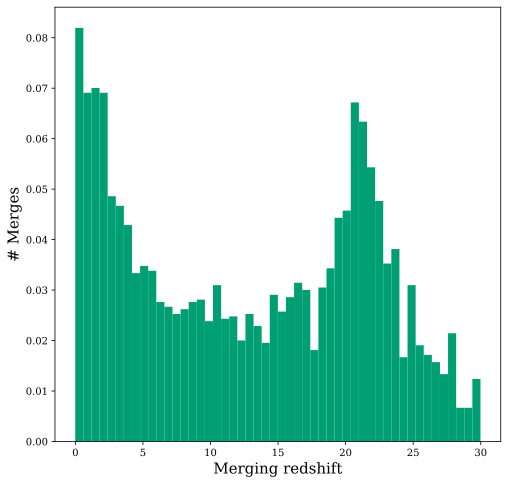

In [819]:
fig, ax = plt.subplots(figsize=(8,8))
merge_time_datas = np.concatenate(t_merge_z) 
ax.hist(merge_time_datas, 50, density=True)
ax.set_xlabel('Merging redshift')
ax.set_ylabel('# Merges')

plt.savefig('/Users/antoninpantalacci/Desktop/Master Project/Simulation/z-merge')


(1e-05, 0.1)

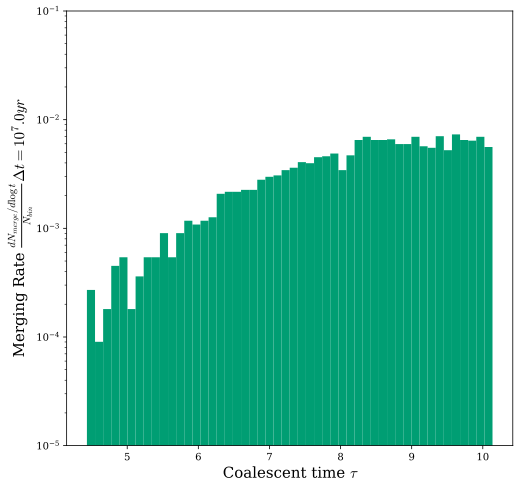

In [803]:
plt.subplots(figsize=(8,8))

coal_time_datas = np.log10(np.concatenate(t_merge))

hist, binsedges = np.histogram(coal_time_datas, bins=50, density=True)

bin_centers = np.sqrt(binsedges[1:] * binsedges[:-1])

n_mergenbin = hist/len(hist)

gamma = n_mergenbin
plt.bar(bin_centers, gamma, width=np.diff(binsedges), align='center', log=True)
# plt.xscale('log')
plt.xlabel(r'Coalescent time $\tau$')
plt.ylabel(r'Merging Rate $\frac{dN_{merge}/d\log{t}}{N_{bin}}$'+ f'$\Delta t =10^{np.log10(dt)}yr$')
plt.savefig('/Users/antoninpantalacci/Desktop/Master Project/Simulation/coalescent-merge')
plt.ylim(1e-5, 1e-1)

There will be  80 steps
la blanquette
est
1000341862.8268657 29.99999999999999
1000938272.9991714 29.795448831600517
1003799222.687938 29.59423874062652
1000181684.2268773 29.396283256865317
1002342772.6917473 29.201498957681938
1000034531.0770272 29.009805332617113
1000012131.9338055 28.82112465522146
1000003676.1913103 28.63538186167499
1000255004.5748608 28.45250443577317
1000115328.5174527 28.272422299890472
1000817016.9016565 28.095067711559082
1000074726.5158588 27.920375165325677
1000000785.6219375 27.74828129957226
1000090357.7230844 27.57872480800817
1000351686.2876996 27.411646355560286
1000932552.2350645 27.246988498406466
1000959901.8756658 27.084695607914178
1000155910.9540402 26.924713798262015
1000507534.0755467 26.766990857535763
1000058426.3595636 26.61147618210482
1000135692.3672414 26.45812071409648
1000071377.4569352 26.30687688179759
1003567723.7241185 26.157698542823614
1000070077.4722904 26.01054092990517
1000957047.6835732 25.86536059915138
1000079548.479883 25.

(1e-05, 0.1)

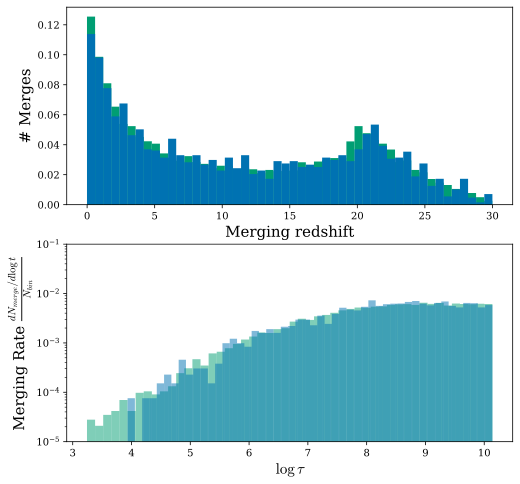

In [840]:
fig, ax = plt.subplots(2, 1, figsize=(8,8))

for i in range(6,8):
    dt = 10**i
    zi = 30
    zf = 20

    z = Redshift_routine(zi, zf, dt)
    print('la blanquette')
    Mhs, MpopIIIs = Mass_routine(z)
    print('est')
    M1_z, M2_z, t_merge_z, t_merge, chirp_mass_z = Merging_Routine(z, Mhs, MpopIIIs)
    print('bonne')

    merge_time_datas = np.concatenate(t_merge_z) 
    ax[0].hist(merge_time_datas, 50, density=True, label = f'$\Delta t =10^{np.log10(dt)}yr$')

    coal_time_datas = np.log10(np.concatenate(t_merge))
    hist, binsedges = np.histogram(coal_time_datas, bins=50, density=True)
    bin_centers = np.sqrt(binsedges[1:] * binsedges[:-1])
    n_mergenbin = hist/len(hist)
    gamma = n_mergenbin
    ax[1].bar(bin_centers, gamma, width=np.diff(binsedges), align='center', log=True, alpha= 0.5, label = f'$\Delta t =10^{np.log10(dt)}yr$')
    # plt.xscale('log')

ax[0].set_xlabel('Merging redshift')
ax[0].set_ylabel('# Merges')
ax[1].set_xlabel(r'$\log{\tau}$')
ax[1].set_ylabel(r'Merging Rate $\frac{dN_{merge}/d\log{t}}{N_{bin}}$')
ax[1].set_ylim(1e-5, 1e-1)


(1e-05, 0.1)

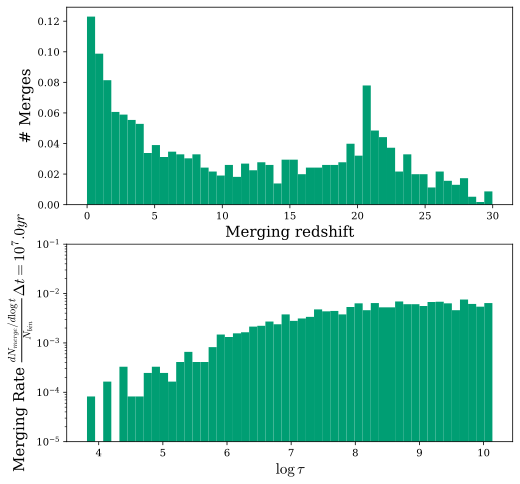

In [836]:
fig, ax = plt.subplots(2, 1, figsize=(8,8))
merge_time_datas = np.concatenate(t_merge_z) 
ax[0].hist(merge_time_datas, 50, density=True)
ax[0].set_xlabel('Merging redshift')
ax[0].set_ylabel('# Merges')


coal_time_datas = np.log10(np.concatenate(t_merge))
hist, binsedges = np.histogram(coal_time_datas, bins=50, density=True)
bin_centers = np.sqrt(binsedges[1:] * binsedges[:-1])
n_mergenbin = hist/len(hist)
gamma = n_mergenbin
ax[1].bar(bin_centers, gamma, width=np.diff(binsedges), align='center', log=True)
# plt.xscale('log')
ax[1].set_xlabel(r'$\log{\tau}$')
ax[1].set_ylabel(r'Merging Rate $\frac{dN_{merge}/d\log{t}}{N_{bin}}$'+ f'$\Delta t =10^{np.log10(dt)}yr$')
ax[1].set_ylim(1e-5, 1e-1)

In [841]:
def Redshift_routine(z_i, z_f, dt):

    t_i = Time_z(z_i)
    t_f = Time_z(z_f)

    n_step = int(np.rint((t_f - t_i)/dt))
    print('There will be ', n_step, 'steps')
    z = []
    simulation_finished = True

    i = 0
    while simulation_finished:
        simulation_finished = redhsift_steps(i, dt, n_step)
        z.append(simulation_finished)
        if not simulation_finished:
            z = z[:-2]
        i+=1

    return z

def Routine(z, PopIII_PDF):
    
    M1_z = []
    M2_z = []
    t_merge_z = []
    t_merge = []
    chirp_mass_z = []

    for i in range(len(z)):
        Halos = HalosGenerator(1e9, z[i])
        Ns = N_StarGenerator(Halos, z[i])[1]
        m_popIIIs = []
        for n in Ns:
            m_popIIIs = np.concatenate((m_popIIIs, Mass_Star_Generator(n, z[i], PopIII_PDF, (-1, 3)).tolist()))

        n = len(m_popIIIs)

        M1=[]
        M2=[]
        binaries = []
        z_binaries = []
        chirp_mass = []
        
        for s in range(int(n/4)):
            M1.append(m_popIIIs[2*s])
            M2.append(m_popIIIs[2*s+1])
            
            binaries.append(Merging_Time(m_popIIIs[2*s], m_popIIIs[2*s+1]))
            z_binaries.append(Redshift_t(Time_z(z[i])+binaries[-1]))
            chirp_mass.append((m_popIIIs[2*s]*m_popIIIs[2*s+1])**(3/5)/(m_popIIIs[2*s]+m_popIIIs[2*s+1])**(1/5))

        chirp_mass_z.append(chirp_mass)
        M1_z.append(M1)
        M2_z.append(M2)
        t_merge.append(np.array(binaries)[np.array(binaries) < Time_z(0)].tolist())
        t_merge_z.append(np.array(z_binaries)[np.array(binaries) < Time_z(0)].tolist())
        # t_merge.append(binaries)
        # t_merge_z.append(z_binaries)
        
    return M1_z, M2_z, t_merge_z, t_merge, chirp_mass_z

In [844]:
dt = 1e7
zi = 30
zf = 20

z = Redshift_routine(zi, zf, dt)

M1_z, M2_z, t_merge_z, t_merge, chirp_mass_z = Routine(z, Susa_IMF_PDF)

merge_time_datas = np.concatenate(t_merge_z) 



coal_time_datas = np.log10(np.concatenate(t_merge))
hist, binsedges = np.histogram(coal_time_datas, bins=50, density=True)
bin_centers = np.sqrt(binsedges[1:] * binsedges[:-1])
n_mergenbin = hist/len(hist)
gamma = n_mergenbin


There will be  8 steps


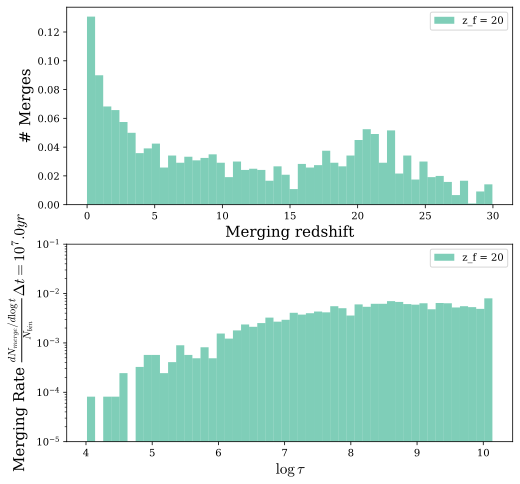

In [850]:

fig, ax = plt.subplots(2, 1, figsize=(8,8))

ax[0].hist(merge_time_datas, 50, density=True, alpha = 0.5, label = f'z_f = {zf}')
ax[1].bar(bin_centers, gamma, width=np.diff(binsedges), align='center', alpha = 0.5, label = f'z_f = {zf}')
ax[1].set_yscale('log')
ax[0].set_xlabel('Merging redshift')
ax[0].set_ylabel('# Merges')
ax[1].set_xlabel(r'$\log{\tau}$')
ax[1].set_ylabel(r'Merging Rate $\frac{dN_{merge}/d\log{t}}{N_{bin}}$'+ f'$\Delta t =10^{np.log10(dt)}yr$')
ax[1].set_ylim(1e-5, 1e-1)
ax[0].legend()
ax[1].legend()